In [1]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [2]:
#required libraris 
import numpy as np
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.compose import make_column_selector as selector
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import KFold

In [3]:
#number of splits for kfolds
no_of_splits=5

In [4]:
# read the from the file and return the dataframe
def readFromTheFile(fileName):
    datasetDataFrame = pd.read_csv(fileName)
    return datasetDataFrame

# display the info of the dataset
def infoAboutDataset(datasetFrame):
    print("Decription of the columns")
    print(datasetFrame.info())
    print()
    print("Description of the dataset")
    print(datasetFrame.describe())
    print("Head of the dataset")
    print(datasetFrame.head())

# split the dataset into x and y
def convertDataFrameIntoXandY(datasetDataFrame, columnx, columny):
    x = datasetDataFrame[columnx].to_numpy()
    y = datasetDataFrame[columny].to_numpy()
    return x, y

# vfscore of the column
def returVfScore(X):
    vif_df = pd.DataFrame()
    vif_df["feature"] = X.columns
    vif_df["VIF"] = [variance_inflation_factor(
        X.values, i) for i in range(len(X.columns))]
    return vif_df

# return standard Error
def returnStandardError(x, mean_res_sq):
    meanValue = x.mean(axis=0)
    SD_features = []
    for i in range(x.shape[1]):
        col = x[:, i]
        mean = meanValue[i]
        diff_from_mean = col - mean
        sq_x = np.dot(diff_from_mean.T, diff_from_mean)
        SD_features.append(math.sqrt(mean_res_sq/sq_x))
    return SD_features

# return t values
def returnTValues(w, se):
    tStats = [i[0]/j for i, j in zip(w, se)]
    return tStats

# return of the correlation matrix
def returnCoreelationMatric(x):
    return np.corrcoef(x.T)


# analysis of the coffecients
def coffecientAnalysis(w, x, y, b):
    # residual_squared =mean_squared_error(y, np.dot(x,w)+b)*x.shape[0]
    # mean_res_sq = residual_squared/(x.shape[0]-2)
    print("==========================================================")
    print("Mean square error of  Regression")
    print(returnMeanSqaure(w, b, x, y))
    # se=returnStandardError(x,mean_res_sq)
    print("==========================================================")
    print("Standard Error of the coffecients")
    # print(se)
    # print("==========================================================")
    # print("T values ")
    # print(returnTValues(w,se))


#min max normalization
def minMaxNormalization(x, y):
    max_value = x.max(axis=0)
    min_value = x.min(axis=0)
    for i in range(0, x.shape[0]):
        for j in range(0, x.shape[1]):
            x[i][j] = (x[i][j]-min_value[j])/(max_value[j]-min_value[j])

    max_value = y.max(axis=0)
    min_value = y.min(axis=0)
    for i in range(0, y.shape[0]):
        y[i] = (y[i]-min_value)/(max_value-min_value)

    return x, y


# ordinary least sqaure method
def fitOls(x, y):
    model = sm.OLS(y, x)
    results = model.fit()
    print(results.params)
    print(results.summary())


# linear regression method
def fitlinearRegression(x, y, numberOfEpochs, learningRate):
    w = np.random.rand(x.shape[1], 1)
    b = np.random.rand(1, 1)
    for i in range(0, numberOfEpochs):
        yPredict = np.dot(x, w)+b
        dw = (1/x.shape[0])*np.dot(x.T, (yPredict-y))
        db = (1/x.shape[0])*np.sum(yPredict-y)
        w = w - (learningRate*dw)
        b = b - (learningRate*db)
    return w, b


# ridge regression method
def fitRidgeRegression(x, y, numberOfEpochs, lambdaValue, learningRate):
    w = np.random.rand(x.shape[1], 1)
    b = np.random.rand(1, 1)
    for i in range(0, numberOfEpochs):
        yPredict = np.dot(x, w)+b
        dw = (1/x.shape[0])*(np.dot(x.T, (yPredict-y))+lambdaValue*w)
        db = (1/x.shape[0])*(np.sum(yPredict-y)+lambdaValue*b)
        w = w - (learningRate*dw)
        b = b - (learningRate*db)
    return w, b

# Elastic regression method
def fitElasticLassoRegression(x, y, numberOfEpochs, lambdaValue, learningRate):
    w = np.random.rand(x.shape[1], 1)
    b = np.random.rand(1, 1)
    for i in range(0, numberOfEpochs):
        yPredict = np.dot(x, w)+b
        dw = (1/x.shape[0])*(np.dot(x.T, (yPredict-y))+lambdaValue*(w/abs(w))+lambdaValue*w)
        db = (1/x.shape[0])*(np.sum(yPredict-y)+lambdaValue*(b/abs(b))+lambdaValue*b)
        w = w - (learningRate*(dw))
        b = b - (learningRate*(db))

    return w, b


# Lasso regression method
def fitLassoRegression(x, y, numberOfEpochs, lambdaValue, learningRate):
    w = np.random.rand(x.shape[1], 1)
    b = np.random.rand(1, 1)
    for i in range(0, numberOfEpochs):
        yPredict = np.dot(x, w)+b
        dw = (1/x.shape[0])*(np.dot(x.T, (yPredict-y))+lambdaValue*(w/abs(w)))
        db = (1/x.shape[0])*(np.sum(yPredict-y)+lambdaValue*(b/abs(b)))
        w = w - (learningRate*(dw))
        b = b - (learningRate*(db))

    return w, b


# graph lasso regression method
def graphLassoRegression(x, y, numberOfEpochs, lambdaValue, learningRate, priorrmatrix):
    correlationMatrix = returnCoreelationMatric(x)
    w = np.random.rand(x.shape[1], 1)
    penalty = np.zeros((x.shape[1], 1))
    b = np.random.rand(1, 1)
    for i in range(0, numberOfEpochs):
        yPredict = np.dot(x, w)+b
        for k in range(0, x.shape[1]):
            derv1 = 0
            derv2 = 0
            for l in range(0, x.shape[1]):
                if correlationMatrix[k][l] >= 0:
                    derv1 = derv1+(priorrmatrix[k][l]*(w[k][0]-w[l][0]))
                else:
                    derv1 = derv1+(priorrmatrix[k][l]*(w[k][0]+w[l][0]))
            for l in range(0, x.shape[1]):
                if correlationMatrix[k][l] >= 0:
                    derv2 = derv2+(priorrmatrix[k][l]*(w[k][0]-w[l][0]))
                else:
                    derv2 = derv2-(priorrmatrix[k][l]*(w[k][0]+w[l][0]))
            penalty[k][0] = 2*(derv1-derv2)
            penalty[k][0] = (1-lambdaValue)*(abs(w[k][0])/w[k]
                                             [0])+(lambdaValue*penalty[k][0])
        dw = (1/x.shape[0])*(np.dot(x.T, (yPredict-y))+penalty)
        db = (1/x.shape[0])*(np.sum(yPredict-y)+(1-lambdaValue)*(b/abs(b)))
        w = w - (learningRate*(dw))
        b = b - (learningRate*(db))
    return w, b


# new approach for regression CGFLASSO
def fitNewApproach(x, y, numberOfEpochs, lambdaValue, learningRate, priorrmatrix):
    correlationMatrix = returnCoreelationMatric(x)
    for i in range(0, x.shape[1]):
        for j in range(0, x.shape[1]):
            # priorrmatrix[i][j] = priorrmatrix[i][j]/(1+(priorrmatrix[i][j]-abs(correlationMatrix[i][j])))
            weightLambda = abs(
                priorrmatrix[i][j])/(1+abs((priorrmatrix[i][j]-correlationMatrix[i][j])))
            priorrmatrix[i][j] = (weightLambda*priorrmatrix[i][j]) + \
                ((1-weightLambda)*correlationMatrix[i][j])

    w = np.random.rand(x.shape[1], 1)
    penalty = np.zeros((x.shape[1], 1))
    b = np.random.rand(1, 1)
    for i in range(0, numberOfEpochs):
        yPredict = np.dot(x, w)+b
        for k in range(0, x.shape[1]):
            derv1 = 0
            derv2 = 0
            for l in range(0, x.shape[1]):
                if correlationMatrix[k][l] >= 0:
                    derv1 = derv1+(priorrmatrix[k][l]*(w[k][0]-w[l][0]))
                else:
                    derv1 = derv1+(priorrmatrix[k][l]*(w[k][0]+w[l][0]))
            for l in range(0, x.shape[1]):
                if correlationMatrix[k][l] >= 0:
                    derv2 = derv2+(priorrmatrix[k][l]*(w[k][0]-w[l][0]))
                else:
                    derv2 = derv2-(priorrmatrix[k][l]*(w[k][0]+w[l][0]))
            penalty[k][0] = 2*(derv1-derv2)
            penalty[k][0] = (1-lambdaValue)*(abs(w[k][0])/w[k]
                                             [0])+(lambdaValue*penalty[k][0])
        dw = (1/x.shape[0])*(np.dot(x.T, (yPredict-y))+penalty)
        db = (1/x.shape[0])*(np.sum(yPredict-y)+(1-lambdaValue)*(b/abs(b)))
        w = w - (learningRate*(dw))
        b = b - (learningRate*(db))
    return w, b


# def for single run
def singleRunAnalysis(x, y, w, b):
    print("==========================================================")
    print("Coffecients")
    print(w)
    coffecientAnalysis(w, x, y, b)


# return mean square error
def returnMeanSqaure(w, b, x, y):
    yPredict = np.dot(x, w)+b
    return np.sum((yPredict-y)**2)/(2*x.shape[0])


In [5]:
df=pd.read_csv('./winequality-red.csv')
df.columns=['fixed activity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol','quality']

In [6]:
df.describe()

,fixed activity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1598.000000,1598.000000,1598.000000,1598.000000,1598.000000,1598.000000,1598.000000,1598.000000,1598.000000,1598.000000,1598.000000,1598.000000
mean,8.320213,0.527713,0.271145,2.539205,0.087474,15.877972,46.475594,0.996746,3.310989,0.658210,10.423623,5.636421
std,1.741489,0.179064,0.194744,1.410279,0.047079,10.462720,32.904142,0.001888,0.154355,0.169542,1.065694,0.807665
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997837,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [7]:
#changing categorical value to the ordinary encoding
categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(df)
encoder = OrdinalEncoder()
for col in df.select_dtypes(include='O').columns:
    df[col] = encoder.fit_transform(df[[col]])

In [8]:
# VfScore of all the column
print(returVfScore(df.drop(['quality'], axis=1)))

                 feature          VIF
0         fixed activity    74.456135
1       volatile acidity    17.043284
2            citric acid     9.187078
3         residual sugar     4.661792
4              chlorides     6.552575
5    free sulfur dioxide     6.442177
6   total sulfur dioxide     6.518329
7                density  1479.125512
8                     pH  1071.330826
9              sulphates    21.581456
10               alcohol   124.408742


In [9]:
#normalizing the dataset
x, y = convertDataFrameIntoXandY(
    df, ['fixed activity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol'], ["quality"])
x, y = minMaxNormalization(x, y)



In [10]:
#spliting the dataset into train and test
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [11]:
#initlization of the Kfold object
kf = KFold(n_splits=no_of_splits)

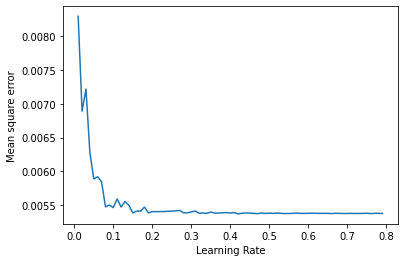

In [13]:
#finding the optimal hyperparamter that is learning rate for OLS
learning_rate = [i/100 for i in range(1, 80)]
merror = []
for i in learning_rate:
  error=0
  for training_index, testing_index in kf.split(x_train):
    X_train, X_test = x_train[training_index,:],x_train[testing_index,:]
    Y_train, Y_test = y_train[training_index] , y_train[testing_index]
    w, b = fitlinearRegression(X_train, Y_train, 3000, i)
    error=error+returnMeanSqaure(w, b, X_test, Y_test)
  merror.append(error/no_of_splits)


plt.plot(learning_rate, merror)
plt.xlabel("Learning Rate")
plt.ylabel("Mean square error")
plt.show()


In [14]:
#getting the mse on test dataset on the optimal hyperparameter
w, b = fitlinearRegression(x_train, y_train, 3000, 0.25)
singleRunAnalysis(x_test, y_test, w, b)
coffecientlist = []
for _ in range(x.shape[1]):
    coffecientlist.append([])

#finding the standard error of the cofficients of the optimal hyperparameter
for _ in range(100):
    w, b = fitlinearRegression(x_train, y_train, 3000, 0.25)
    for i in range(x.shape[1]):
        coffecientlist[i].append(w[i][0])


for i in range(x.shape[1]):
    print(np.array(coffecientlist[i]).std())


Coffecients
[[ 0.11222605]
 [ 0.03057663]
 [ 0.02669967]
 [ 0.07605501]
 [-0.03194297]
 [-0.01696266]
 [-0.00051086]
 [-0.16897106]
 [ 0.03468242]
 [ 0.07539156]
 [ 0.02370495]]
Mean square error of  Regression
0.006038195640599117
Standard Error of the coffecients
0.06093941183411891
0.010027097957599866
0.008864303370038512
0.033063323645381816
0.02264760433512525
0.008471377161046333
0.01593835944205386
0.061820037457582105
0.04459467596842794
0.016092421920761348
0.02987372056986288


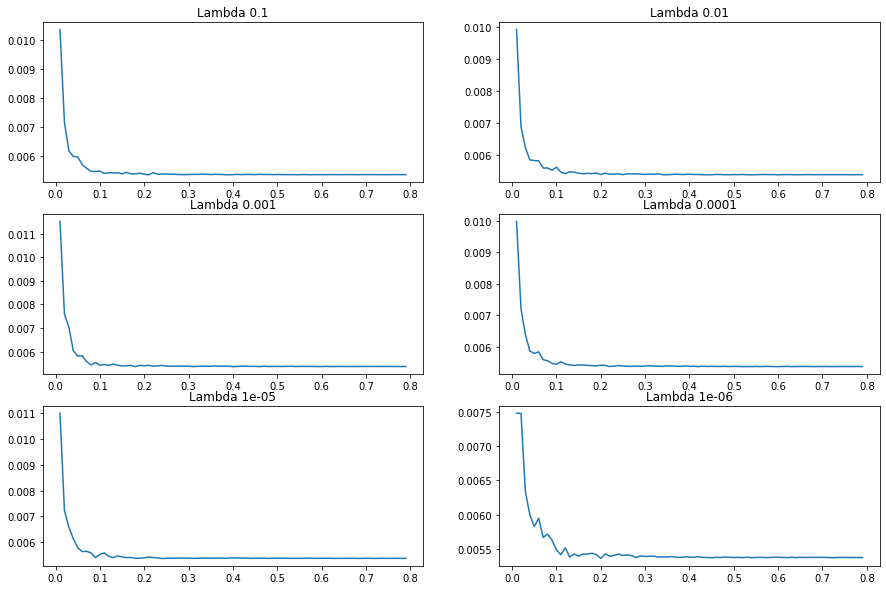

In [15]:
#finding the optimal hyperparamter that is learning rate and regularization constant for ridge regression
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
lambda_value = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
sx = 0
sy = 0
for j in lambda_value:
    merror = []
    for i in learning_rate:
        error=0
        for training_index, testing_index in kf.split(x_train):
          X_train, X_test = x_train[training_index,:],x_train[testing_index,:]
          Y_train, Y_test = y_train[training_index] , y_train[testing_index]
          w, b = fitRidgeRegression(X_train, Y_train, 3000, j, i)
          error=error+returnMeanSqaure(w, b, X_test, Y_test)
        merror.append(error/no_of_splits)



    axs[sx, sy].plot(learning_rate, merror)
    axs[sx, sy].title.set_text("Lambda {}".format(j))
    sy = sy+1
    if sy % 2 == 0:
        sx = sx+1
        sy = 0


plt.show()

In [16]:
#getting the mse on test dataset on the optimal hyperparameters
w, b = fitRidgeRegression(x_train, y_train, 3000, 0.01, 0.5)
singleRunAnalysis(x_test, y_test, w, b)
coffecientlist = []
for _ in range(x.shape[1]):
    coffecientlist.append([])

#finding the standard error of the cofficients of the optimal hyperparameters
for _ in range(100):
    w, b = fitRidgeRegression(x_train, y_train, 3000, 0.01, 0.5)
    for i in range(x.shape[1]):
        coffecientlist[i].append(w[i][0])

for i in range(x.shape[1]):
    print(np.array(coffecientlist[i]).std())


Coffecients
[[-0.00544064]
 [ 0.03746921]
 [ 0.04107043]
 [ 0.02795691]
 [-0.07164777]
 [-0.00138755]
 [-0.03021646]
 [-0.06686165]
 [-0.05649697]
 [ 0.06496166]
 [ 0.06697009]]
Mean square error of  Regression
0.005950370023973186
Standard Error of the coffecients
0.030109071967487834
0.0010695684204920675
0.002659486553396005
0.015314576510231697
0.005997827455854582
0.003002509733493255
0.0048911861806737985
0.029632929999217152
0.022010062821128412
0.005338700452650716
0.01370475059309045


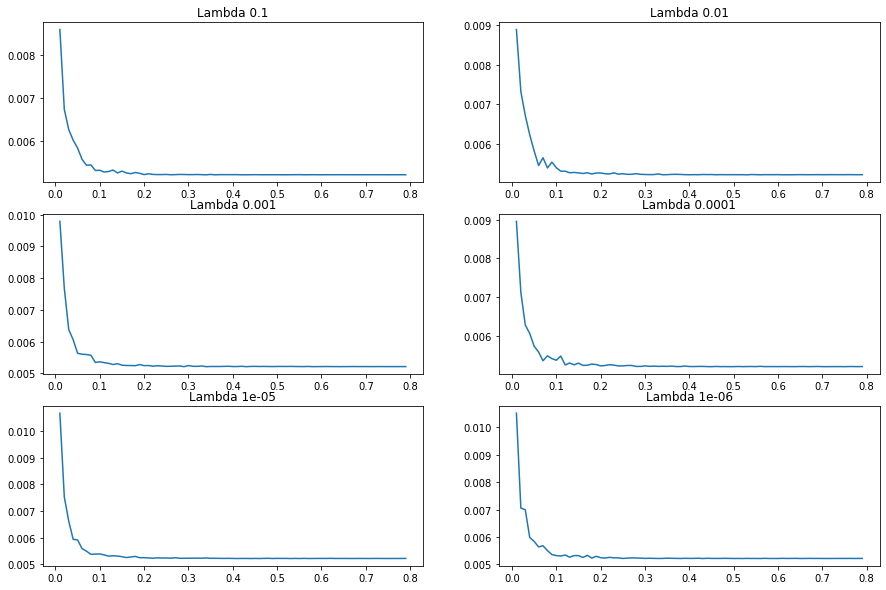

In [17]:
#finding the optimal hyperparamter that is learning rate and regularization constant for lasso regression
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
lambda_value = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
sx = 0
sy = 0
for j in lambda_value:
    merror = []
    for i in learning_rate:
        error=0
        for training_index, testing_index in kf.split(x_train):
          X_train, X_test = x_train[training_index,:],x_train[testing_index,:]
          Y_train, Y_test = y_train[training_index] , y_train[testing_index]
          w, b = fitLassoRegression(x, y, 3000, j, i)
          error=error+returnMeanSqaure(w, b, X_test, Y_test)
        merror.append(error/no_of_splits)

    axs[sx, sy].plot(learning_rate, merror)
    axs[sx, sy].title.set_text("Lambda {}".format(j))
    sy = sy+1
    if sy % 2 == 0:
        sx = sx+1
        sy = 0


plt.show()


In [18]:
#getting the mse on test dataset on the optimal hyperparameters
w, b = fitLassoRegression(x_train, y_train, 3000, 0.0001, 0.3)
singleRunAnalysis(x_test, y_test, w, b)
coffecientlist = []
for _ in range(x.shape[1]):
    coffecientlist.append([])

#finding the standard error of the cofficients of the optimal hyperparameters
for _ in range(100):
    w, b = fitLassoRegression(x_train, y_train, 3000, 0.0001, 0.3)
    for i in range(x.shape[1]):
        coffecientlist[i].append(w[i][0])

for i in range(x.shape[1]):
    print(np.array(coffecientlist[i]).std())


Coffecients
[[-0.03785261]
 [ 0.03475532]
 [ 0.04152086]
 [ 0.00844199]
 [-0.07352963]
 [-0.00052829]
 [-0.03049094]
 [-0.03086361]
 [-0.07949643]
 [ 0.05733624]
 [ 0.08479518]]
Mean square error of  Regression
0.005929088190764378
Standard Error of the coffecients
0.061938080693115516
0.006721768151485784
0.007682357296349439
0.031296942568757556
0.018783097737263714
0.0074099463265484685
0.013296236539565378
0.060336868172434326
0.04534243489173337
0.012136247898778589
0.02795107997270674


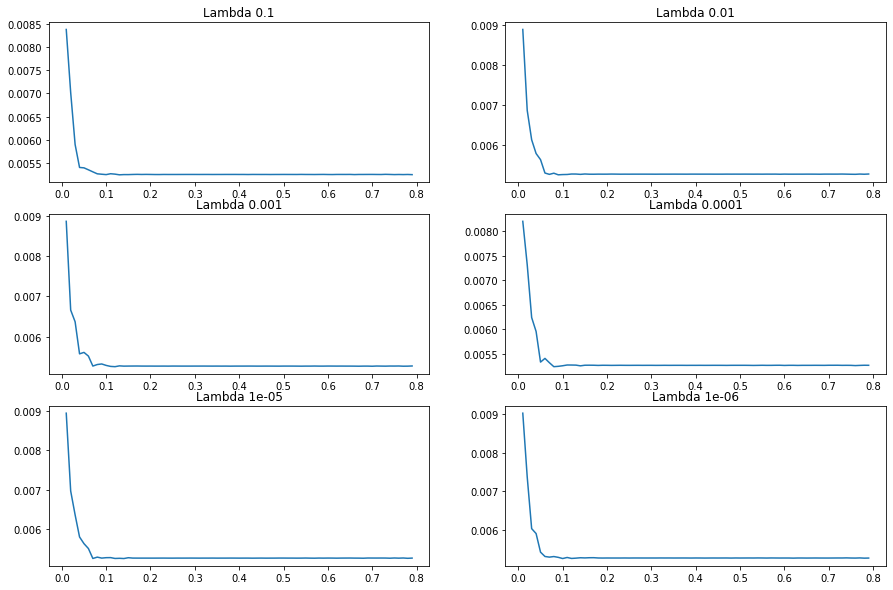

In [19]:
#finding the optimal hyperparamter that is learning rate and regularization constant for graph lasso regression

#building the priormatrix accodring to the Graph lasso research paper 
prioirmatrix = np.corrcoef(x_train, x_train)
for i in range(0,x_train.shape[0]):
  for j in range(0,x_train.shape[1]):
    if abs(prioirmatrix[i][j])>0.5:
      prioirmatrix[i][j]=1
    else:
      prioirmatrix[i][j]=0


fig, axs = plt.subplots(3, 2, figsize=(15, 10))
lambda_value = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
sx = 0
sy = 0
for j in lambda_value:
    merror = []
    for i in learning_rate:
        error=0
        for training_index, testing_index in kf.split(x_train):
          X_train, X_test = x_train[training_index,:],x_train[testing_index,:]
          Y_train, Y_test = y_train[training_index] , y_train[testing_index]
          w, b = graphLassoRegression(x, y, 3000, j, i, prioirmatrix)
          error=error+returnMeanSqaure(w, b, X_test, Y_test)
        merror.append(error/no_of_splits)

    axs[sx, sy].plot(learning_rate, merror)
    axs[sx, sy].title.set_text("Lambda {}".format(j))
    sy = sy+1
    if sy % 2 == 0:
        sx = sx+1
        sy = 0


plt.show()

In [20]:
#getting the mse on test dataset on the optimal hyperparameters
w, b = graphLassoRegression(x, y, 3000, 0.001, 0.5, prioirmatrix)
singleRunAnalysis(x, y, w, b)


coffecientlist = []
for _ in range(x.shape[1]):
    coffecientlist.append([])

#finding the standard error of the cofficients of the optimal hyperparameters
for _ in range(100):
    w, b = graphLassoRegression(x, y, 3000, 0.001, 0.5, prioirmatrix)
    for i in range(x.shape[1]):
        coffecientlist[i].append(w[i][0])

for i in range(x.shape[1]):
    print(np.array(coffecientlist[i]).std())


Coffecients
[[-2.63717661e-04]
 [-3.52620885e-04]
 [ 3.60598107e-03]
 [ 7.95299865e-05]
 [-3.17559320e-04]
 [-1.11368082e-04]
 [ 1.30754668e-04]
 [-8.11612232e-03]
 [-2.05055330e-02]
 [-4.30984179e-05]
 [ 7.80475264e-02]]
Mean square error of  Regression
0.005406524756078411
Standard Error of the coffecients
0.00019666658005246696
0.00019510731670317971
3.486796587254256e-05
0.00020144722177163233
0.00018980544477357306
0.00018321800446844161
0.0001790662088091138
6.18023909256923e-05
5.55827539869936e-05
0.00018488439774163988
3.867292885802002e-05


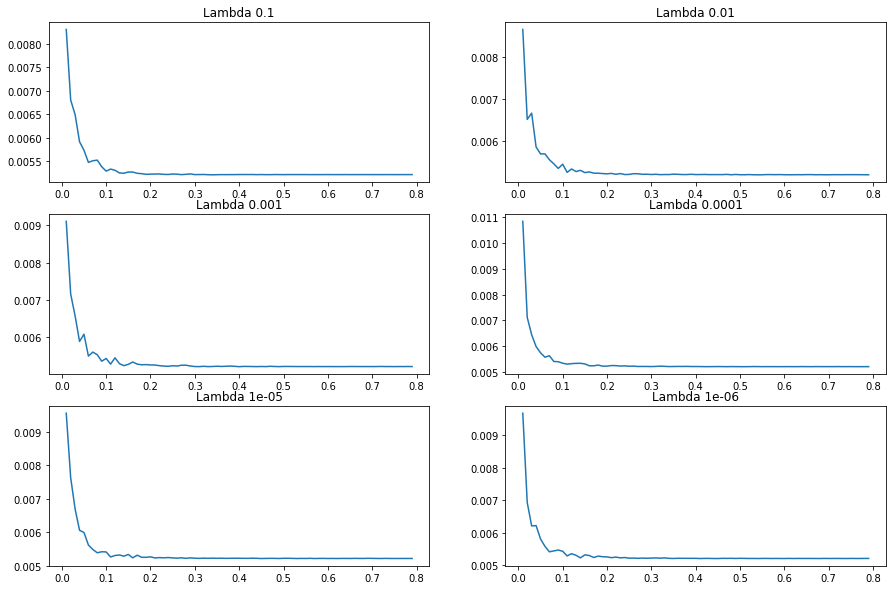

In [21]:
#finding the optimal hyperparamter that is learning rate and regularization constant for Elastic lasso regression
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
lambda_value = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
sx = 0
sy = 0
for j in lambda_value:
    merror = []
    for i in learning_rate:
        error=0
        for training_index, testing_index in kf.split(x_train):
          X_train, X_test = x_train[training_index,:],x_train[testing_index,:]
          Y_train, Y_test = y_train[training_index] , y_train[testing_index]
          w, b = fitElasticLassoRegression(x, y, 3000, j, i)
          error=error+returnMeanSqaure(w, b, X_test, Y_test)
        merror.append(error/no_of_splits)

    axs[sx, sy].plot(learning_rate, merror)
    axs[sx, sy].title.set_text("Lambda {}".format(j))
    sy = sy+1
    if sy % 2 == 0:
        sx = sx+1
        sy = 0


plt.show()


In [22]:
#getting the mse on test dataset on the optimal hyperparameters
w, b = fitElasticLassoRegression(x, y, 3000, 0.1, 0.7,)
singleRunAnalysis(x, y, w, b)
coffecientlist = []
for _ in range(x.shape[1]):
    coffecientlist.append([])

#finding the standard error of the cofficients of the optimal hyperparameters
for _ in range(100):
    w, b = fitElasticLassoRegression(x, y, 3000, 0.1, 0.7)
    for i in range(x.shape[1]):
        coffecientlist[i].append(w[i][0])

for i in range(x.shape[1]):
    print(np.array(coffecientlist[i]).std())


Coffecients
[[-1.41756772e-02]
 [ 8.58305757e-03]
 [ 2.08361118e-02]
 [ 3.88463888e-05]
 [-5.03653904e-02]
 [-3.23371977e-03]
 [-9.63001440e-03]
 [-2.30783662e-02]
 [-5.00115619e-02]
 [ 5.52390558e-02]
 [ 9.14244820e-02]]
Mean square error of  Regression
0.005359323901919377
Standard Error of the coffecients
0.004033510024450873
0.00020897954854894466
0.0002455699579346109
0.0008740887483585629
0.0008232103393254252
0.0002521564424321731
0.0007419326643055063
0.003729225964448776
0.00294182635174701
0.0007037100652448039
0.0017381521150968756


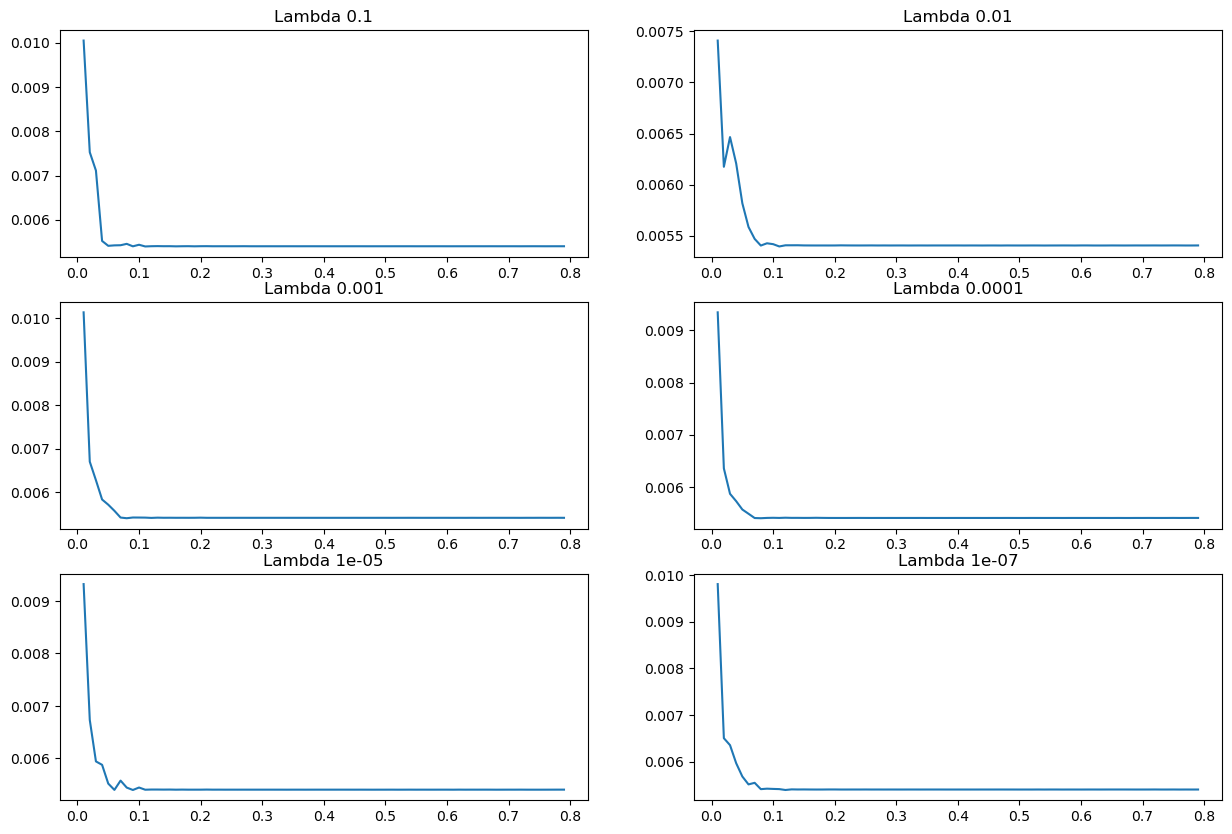

In [13]:
#finding the optimal hyperparamter that is learning rate and regularization constant for CGFLASSO(NEW APPROACH) regression

#building the priormatrix accodring to the knowledge of the dataset
pmatrix=[[1,1,0,0,0,0,0,0,1,0,1],
             [1,1,0,0,0,0,0,0,1,0,1],
             [0,0,1,0,0,0,0,0,1,0,0],
             [0,0,0,1,0,0,0,1,0,0,0],
             [0,0,0,0,1,0,0,1,1,0,0],
             [0,0,0,0,0,1,1,1,0,0,0],
             [0,0,0,0,0,1,1,1,0,1,0],
             [0,0,0,1,1,1,1,1,1,0,1],
             [1,1,1,0,1,0,0,1,1,0,0],
             [0,0,0,0,0,0,1,0,0,1,0],
             [0,0,0,0,0,0,0,1,0,0,1]]


learning_rate = [i/100 for i in range(1, 80)]

fig, axs = plt.subplots(3, 2, figsize=(15, 10))
lambda_value = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.0000001]
sx = 0
sy = 0
for j in lambda_value:
    merror = []
    for i in learning_rate:
        w, b = fitNewApproach(x, y, 3000, j, i, pmatrix)
        merror.append(returnMeanSqaure(w, b, x, y))

    axs[sx, sy].plot(learning_rate, merror)
    axs[sx, sy].title.set_text("Lambda {}".format(j))
    sy = sy+1
    if sy % 2 == 0:
        sx = sx+1
        sy = 0

plt.show()


In [14]:
#getting the mse on test dataset on the optimal hyperparameters
w, b = fitNewApproach(x, y, 3000, 0.0001, 0.5, pmatrix)
singleRunAnalysis(x, y, w, b)
coffecientlist = []
for _ in range(x.shape[1]):
    coffecientlist.append([])

#finding the standard error of the cofficients of the optimal hyperparameters
for _ in range(100):
    w, b = fitNewApproach(x, y, 3000, 0.0001, 0.5, pmatrix)
    for i in range(x.shape[1]):
        coffecientlist[i].append(w[i][0])

for i in range(x.shape[1]):
    print(np.array(coffecientlist[i]).std())


Coffecients
[[-1.62541784e-04]
 [-5.52861175e-04]
 [ 3.51794602e-03]
 [ 1.23924436e-04]
 [ 1.28686083e-04]
 [-9.84950887e-05]
 [-2.19605005e-04]
 [-8.21438167e-03]
 [-2.06120172e-02]
 [ 1.76349279e-04]
 [ 7.79630159e-02]]
Mean square error of  Regression
0.005406328173283824
Standard Error of the coffecients
0.0001866391157976644
0.0001918290800468731
3.573027230747206e-05
0.00017681888116543999
0.00016991483756760136
0.00018132811278341203
0.00018047580208998618
6.14160051720078e-05
5.790954106508689e-05
0.0001705366274682291
3.813160341770127e-05


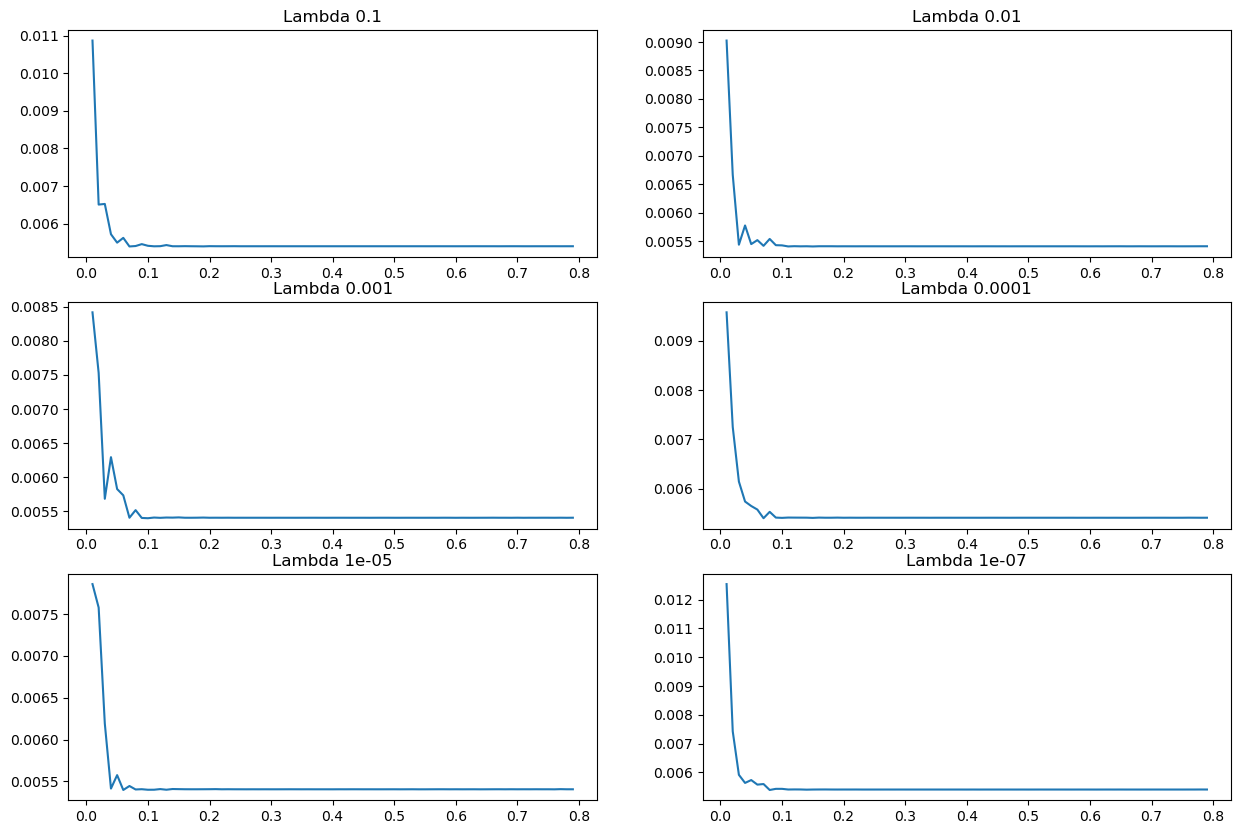

In [19]:
#finding the optimal hyperparamter that is learning rate and regularization constant for CGFLASSO(NEW APPROACH) regression

#building the priormatrix similar to the corrleation matrix value
pmatrix=df.drop(['quality'], axis=1).corr().round(1).to_numpy()

learning_rate = [i/100 for i in range(1, 80)]

fig, axs = plt.subplots(3, 2, figsize=(15, 10))
lambda_value = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.0000001]
sx = 0
sy = 0
for j in lambda_value:
    merror = []
    for i in learning_rate:
        w, b = fitNewApproach(x, y, 3000, j, i, pmatrix)
        merror.append(returnMeanSqaure(w, b, x, y))

    axs[sx, sy].plot(learning_rate, merror)
    axs[sx, sy].title.set_text("Lambda {}".format(j))
    sy = sy+1
    if sy % 2 == 0:
        sx = sx+1
        sy = 0

plt.show()


In [20]:
#getting the mse on test dataset on the optimal hyperparameters
w, b = fitNewApproach(x, y, 3000, 0.001, 0.5, pmatrix)
singleRunAnalysis(x, y, w, b)
coffecientlist = []
for _ in range(x.shape[1]):
    coffecientlist.append([])

#finding the standard error of the cofficients of the optimal hyperparameters
for _ in range(100):
    w, b = fitNewApproach(x, y, 3000, 0.001, 0.5, pmatrix)
    for i in range(x.shape[1]):
        coffecientlist[i].append(w[i][0])

for i in range(x.shape[1]):
    print(np.array(coffecientlist[i]).std())


Coffecients
[[-7.83299197e-05]
 [-6.58591491e-05]
 [ 3.52004180e-03]
 [-2.48381364e-04]
 [-4.31083118e-04]
 [ 9.35769887e-05]
 [-2.97208215e-04]
 [-8.19799417e-03]
 [-2.06339111e-02]
 [ 9.29247819e-05]
 [ 7.80192059e-02]]
Mean square error of  Regression
0.005406427351082609
Standard Error of the coffecients
0.00018320122460262003
0.00017838870757794513
3.3733707068737304e-05
0.0001992566327757655
0.00018694102612306016
0.00018826413605686992
0.0001832125730450283
6.015929912977708e-05
5.0987887098273574e-05
0.00018171626541798434
3.767858453652663e-05


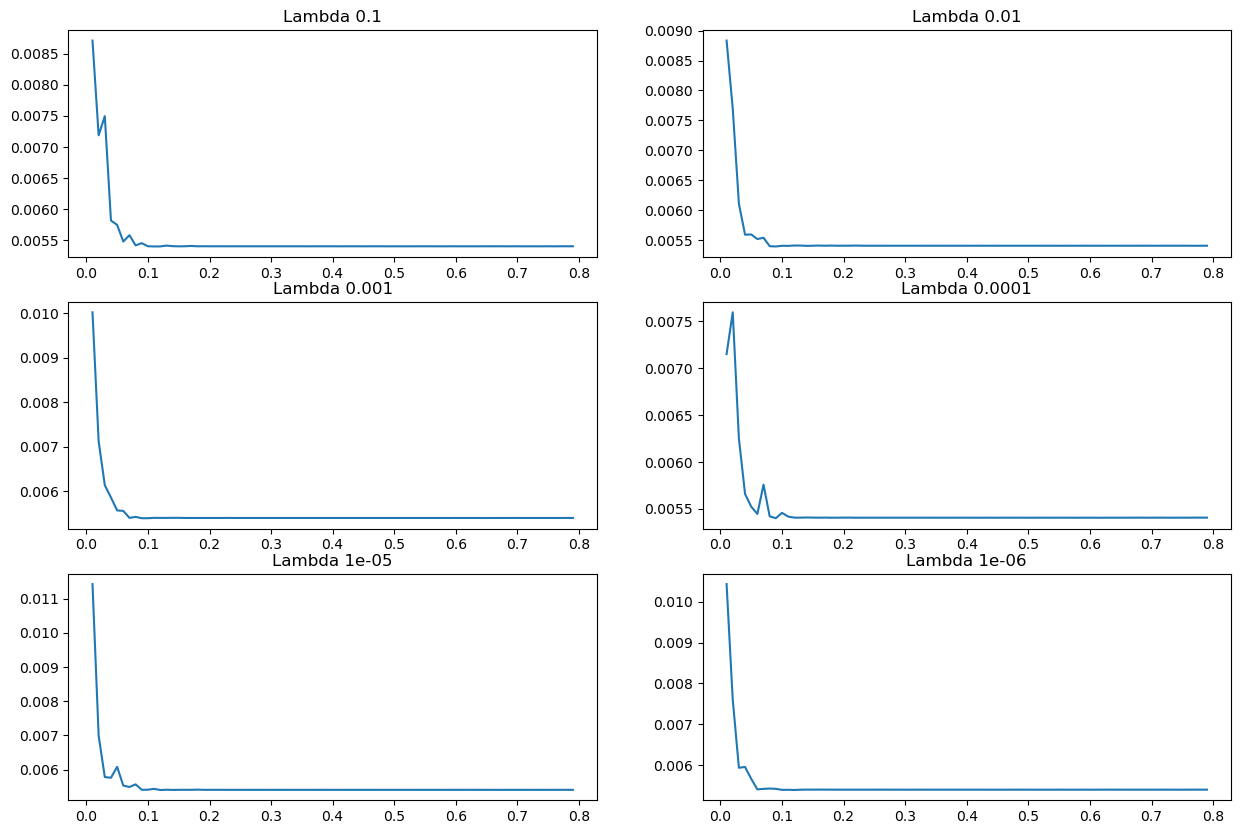

In [14]:
#finding the optimal hyperparamter that is learning rate and regularization constant for CGFLASSO(NEW APPROACH) regression

#building the priormatrix same like Graph Lasso
learning_rate = [i/100 for i in range(1, 80)]
pmatrix=df.drop(['quality'], axis=1).corr().to_numpy()
for i in range(0,x_train.shape[1]):
  for j in range(0,x_train.shape[1]):
    if abs(pmatrix[i][j])>0.5:
      pmatrix[i][j]=1
    else:
      pmatrix[i][j]=0

fig, axs = plt.subplots(3, 2, figsize=(15, 10))
lambda_value = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
sx = 0
sy = 0
for j in lambda_value:
    merror = []
    for i in learning_rate:
        w, b = fitNewApproach(x, y, 3000, j, i, pmatrix)
        merror.append(returnMeanSqaure(w, b, x, y))

    axs[sx, sy].plot(learning_rate, merror)
    axs[sx, sy].title.set_text("Lambda {}".format(j))
    sy = sy+1
    if sy % 2 == 0:
        sx = sx+1
        sy = 0

plt.show()


In [17]:
#getting the mse on test dataset on the optimal hyperparameters
w, b = fitNewApproach(x, y, 3000, 0.0001, 0.5, pmatrix)
singleRunAnalysis(x, y, w, b)
coffecientlist = []
for _ in range(x.shape[1]):
    coffecientlist.append([])

#finding the standard error of the cofficients of the optimal hyperparameters
for _ in range(100):
    w, b = fitNewApproach(x, y, 3000, 0.0001, 0.5, pmatrix)
    for i in range(x.shape[1]):
        coffecientlist[i].append(w[i][0])

for i in range(x.shape[1]):
    print(np.array(coffecientlist[i]).std())


Coffecients
[[ 1.50877852e-04]
 [-2.77786951e-04]
 [ 3.58186171e-03]
 [-1.82830243e-04]
 [ 8.17901573e-05]
 [-2.26729682e-04]
 [-1.19771128e-04]
 [-8.08897745e-03]
 [-2.04936002e-02]
 [ 4.41040254e-04]
 [ 7.80481503e-02]]
Mean square error of  Regression
0.005406357274157409
Standard Error of the coffecients
0.0001833202034900671
0.00016824220728200778
3.0994337803668984e-05
0.0001889693188871084
0.00019636958060808868
0.00018791961248279613
0.0001861815681842361
5.6169057161009315e-05
5.16288697821072e-05
0.00018156553197073953
3.4761342346284596e-05


In [17]:
#finding the standdeviation of the standerror of the coffecients on different priormatrix 
learning_rate = [i/100 for i in range(1, 80)]
stanalysis=[[] for j in range(0,x.shape[1])]
for a in range(0,50):
        coff=np.random.rand()
        epsilon=np.random.uniform(low=0, high=0.05)
        if coff < 0.5:
             epsilon=-1*epsilon
        pmatrix=df.drop(['quality'], axis=1).corr().to_numpy()
        for i in range(0,x_train.shape[1]):
            for j in range(0,x_train.shape[1]):
                 pmatrix[i][j]=pmatrix[i][j]+epsilon
                 if pmatrix[i][j] > 1:
                      pmatrix[i][j]=1
                 elif pmatrix[i][j] < 0:
                      pmatrix[i][j]=0
    
        lambda_value = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
        pmses=[]
        for j in lambda_value:
            pmses.append([])
            t=len(pmses)-1
            for i in learning_rate:
                w, b = fitNewApproach(x, y, 3000, j, i, pmatrix)
                temp=returnMeanSqaure(w, b, x, y)
                pmses[t].append(temp)
        

        rlambda=0
        rlearning=0
        tmin=1e9
        for i in range(0,len(lambda_value)):
             temp=min(pmses[i])
             index=np.where(pmses == temp)[0][0]
             if temp < tmin:
                  tmin=temp
                  rlambda=lambda_value[i]
                  rlearning=index/100
        coffecientlist = []
        for _ in range(x.shape[1]):
             coffecientlist.append([])
        for _ in range(100):
             w, b = fitNewApproach(x, y, 3000, rlambda, rlearning, pmatrix)
             for i in range(0,x.shape[1]):
                  coffecientlist[i].append(w[i][0])
        for i in range(0,x.shape[1]):
               stanalysis[i].append(np.array(coffecientlist[i]).std())



for i in range(x.shape[1]):
        print(np.array(stanalysis[i]).std())

0.0696663954422004
0.07997042810878002
0.09101827634804362
0.08013826994950414
0.06310651238145053
0.09253836105515509
0.07908017363910542
0.06893341065423868
0.07120023034216466
0.0782151803181614
0.08879893144039579
